![Py4Eng](img/logo.png)

# Requests: HTTP for Humans
## Yoav Ram

In this session we'll learn to use the [requests](docs.python-requests.org/) package to easily send HTTP requests.
Install, if not already installed, with `conda install requests` or `pip install requests`.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import pandas as pd
import io
import seaborn as sns
sns.set_style('white')
sns.set_context('talk', font_scale=1.3)

requests allows us to communicate with web APIs. 

For example, we'll use the [World Bank Climate API](http://data.worldbank.org/developers/climate-data-api) to get some data and plot it.

The Climate API has several endpoints; we'll use the country endpoint:
```
http://climatedataapi.worldbank.org/climateweb/rest/v1/country/{type}/{var}/{start}/{end}/{ISO3}.{ext}
```
- `type` is the data type, like `mavg` which is monthly average
- `var` is the variable - `tas` is temperature in Celsius
- `start` and `end` are years, corresponding to specific ranges (see docs)
- `ISO3` is a country code
- `ext` is the data format, like `CSV` or `JSON`

Let's get the monthly average temperature in Israel between 1980 and 1999.

In [1]:
base_url = 'http://climatedataapi.worldbank.org/climateweb/rest/v1/country/{type}/{var}/{start}/{end}/{ISO3}.{ext}'
url = base_url.format(
    type='mavg', 
    var='tas', 
    start='1980', 
    end='1999', 
    ISO3='ISR',
    ext='CSV'
)
print(url)

http://climatedataapi.worldbank.org/climateweb/rest/v1/country/mavg/tas/1980/1999/ISR.CSV


You can click the URL to verify that it is valid.

Now we `requests.get` to get the data at the URL, and check that it returned ok:

In [8]:
r = requests.get(url)
r.ok

True

The data is textual so we can print it:

In [4]:
print(r.text)

GCM,var,from_year,to_year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
bccr_bcm2_0,tas,1980,1999,8.594573975,8.757946777,12.57537842,16.69530029,20.41315918,25.31522217,27.47595825,28.14610596,25.14344482,20.96210937,14.43179932,10.41881714
cccma_cgcm3_1,tas,1980,1999,6.280993652,8.580639648,12.74428711,16.52545166,22.13335571,27.51535645,29.61068115,29.19720459,26.05150146,20.656604,12.97927246,7.531481934
cnrm_cm3,tas,1980,1999,6.547192383,8.257971191,11.77634888,15.43874512,20.20044556,23.84338379,26.82471313,28.40269775,25.03937378,20.12583618,13.62856445,8.344073486
csiro_mk3_5,tas,1980,1999,12.49906616,14.29511719,17.51575928,20.64786377,24.00043335,28.03111572,29.41047974,28.95617065,25.85397339,21.93880615,16.61158447,12.81826782
gfdl_cm2_0,tas,1980,1999,7.266522216797999,8.5183227539,11.639929199204001,16.2017211914,19.15825805662,23.14456787112,25.228820800780003,25.28056640626,22.753253173820003,17.92176513672,12.75487060546,9.115472412104001
gfdl_cm2_1,tas,1980,1999,8.51

But actually we'd like to load it into a data frame. We wrap the string in a `io.StringIO` object that creates a file-like object from the string:

In [11]:
with io.StringIO(r.text) as f:
    data = pd.read_csv(f)
data.head()

,GCM,var,from_year,to_year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,bccr_bcm2_0,tas,1980,1999,8.594574,8.757947,12.575378,16.695300,20.413159,25.315222,27.475958,28.146106,25.143445,20.962109,14.431799,10.418817
1,cccma_cgcm3_1,tas,1980,1999,6.280994,8.580640,12.744287,16.525452,22.133356,27.515356,29.610681,29.197205,26.051501,20.656604,12.979272,7.531482
2,cnrm_cm3,tas,1980,1999,6.547192,8.257971,11.776349,15.438745,20.200446,23.843384,26.824713,28.402698,25.039374,20.125836,13.628564,8.344073
3,csiro_mk3_5,tas,1980,1999,12.499066,14.295117,17.515759,20.647864,24.000433,28.031116,29.410480,28.956171,25.853973,21.938806,16.611584,12.818268
4,gfdl_cm2_0,tas,1980,1999,7.266522,8.518323,11.639929,16.201721,19.158258,23.144568,25.228821,25.280566,22.753253,17.921765,12.754871,9.115472


Now we melt the data so that each monthly measurement is on a separate row:

In [12]:
data = pd.melt(
    data,  
    id_vars=['GCM', 'var', 'from_year', 'to_year'],    
    value_name='Temp.',
    var_name='Month'
)
data.head()

,GCM,var,from_year,to_year,Month,Temp.
0,bccr_bcm2_0,tas,1980,1999,Jan,8.594574
1,cccma_cgcm3_1,tas,1980,1999,Jan,6.280994
2,cnrm_cm3,tas,1980,1999,Jan,6.547192
3,csiro_mk3_5,tas,1980,1999,Jan,12.499066
4,gfdl_cm2_0,tas,1980,1999,Jan,7.266522


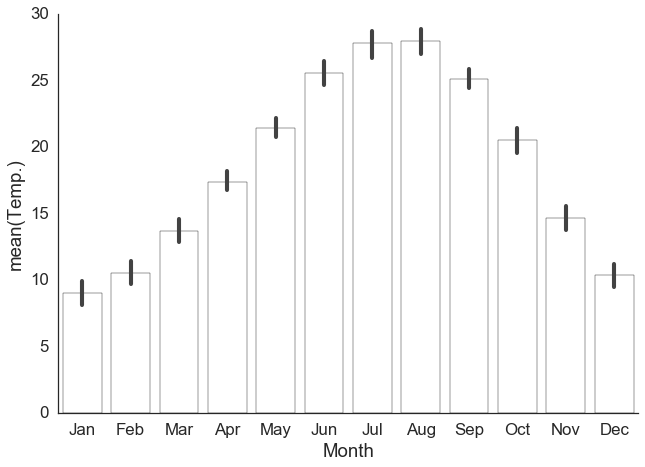

In [22]:
sns.barplot('Month', 'Temp.', data=data, color='w')
sns.despine()

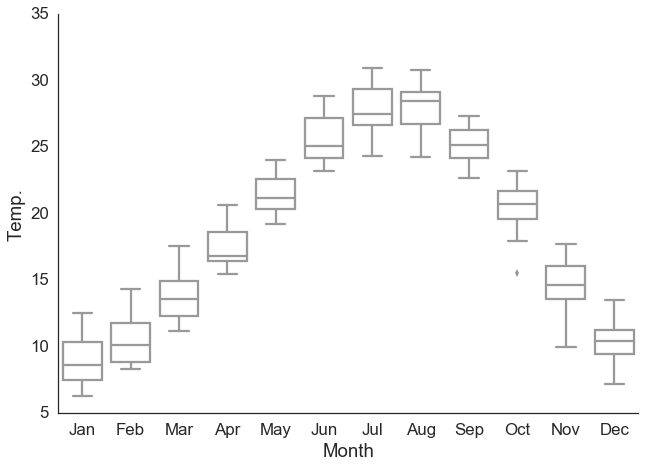

In [23]:
sns.boxplot(x='Month', y='Temp.', data=data, color='w')
sns.despine()

## Stack exchange API

Next, we connect to the [Stack exchange API](https://api.stackexchange.com/docs/tags) to find the most popular tags.

Let's get the 10 most popular tags on stackoverflow - sort by populat, descending order, and limit response to 10 items:

In [25]:
base_url = "https://api.stackexchange.com"
query = "/2.2/tags?page=1&pagesize=10&order=desc&sort=popular&site=stackoverflow"

r = requests.get(base_url + query)
r.ok

True

Here the response is in JSON format, which requests parses for us using the `json` function:

In [26]:
data = r.json()
data.keys()

dict_keys(['quota_max', 'items', 'has_more', 'quota_remaining'])

In [28]:
data['items'][:5]

[{'count': 1074056,
  'has_synonyms': True,
  'is_moderator_only': False,
  'is_required': False,
  'name': 'javascript'},
 {'count': 1031514,
  'has_synonyms': True,
  'is_moderator_only': False,
  'is_required': False,
  'name': 'java'},
 {'count': 922391,
  'has_synonyms': True,
  'is_moderator_only': False,
  'is_required': False,
  'name': 'c#'},
 {'count': 889952,
  'has_synonyms': True,
  'is_moderator_only': False,
  'is_required': False,
  'name': 'php'},
 {'count': 805395,
  'has_synonyms': True,
  'is_moderator_only': False,
  'is_required': False,
  'name': 'android'}]

The `items` member of the response can be given to pandas to create a data frame:

In [29]:
df = pd.DataFrame(r.json()['items'])
df

,count,has_synonyms,is_moderator_only,is_required,name
0,1074056,True,False,False,javascript
1,1031514,True,False,False,java
2,922391,True,False,False,c#
3,889952,True,False,False,php
4,805395,True,False,False,android
5,715290,True,False,False,jquery
6,547142,True,False,False,python
7,514194,True,False,False,html
8,433817,True,False,False,c++
9,416692,True,False,False,ios


Matlab isn't here, so let's do another query to get tags in that contains `matlab` (the `inname` query argument):

In [31]:
query = '/2.2/tags?page=1&pagesize=1&order=desc&sort=popular&inname=matlab&site=stackoverflow'
r = requests.get(base_url + query)
r.ok

True

In [32]:
mdf = pd.DataFrame(r.json()['items'])
mdf

,count,has_synonyms,is_moderator_only,is_required,name
0,58200,True,False,False,matlab


We concat the two data frames and sort them by the `count` column:

In [33]:
df = pd.concat((df, mdf))
df.sort_values('count', ascending=False, inplace=True)
df

,count,has_synonyms,is_moderator_only,is_required,name
0,1074056,True,False,False,javascript
1,1031514,True,False,False,java
2,922391,True,False,False,c#
3,889952,True,False,False,php
4,805395,True,False,False,android
5,715290,True,False,False,jquery
6,547142,True,False,False,python
7,514194,True,False,False,html
8,433817,True,False,False,c++
9,416692,True,False,False,ios


We find the indexes for `python` and `matlab` in the `name` column in which 

In [37]:
names = df.name.tolist()
python_idx = names.index('python')
matlab_idx = names.index('matlab')
python_idx, matlab_idx

(6, 10)

Finally, we plot a bat plot of the counts, and highlight the python and matlab bars by coloring them:

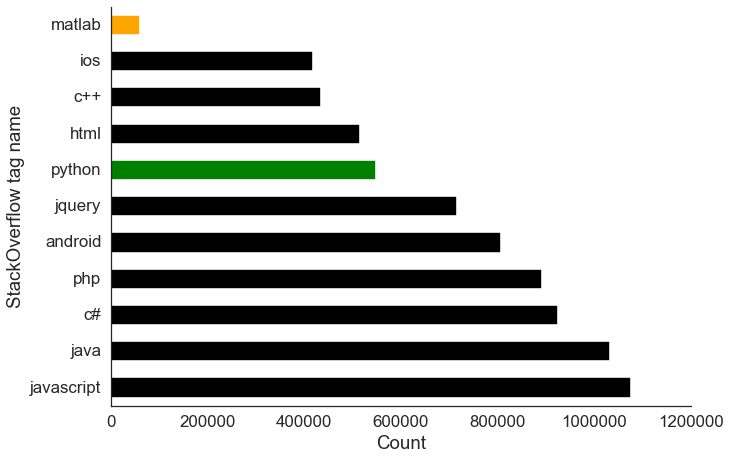

In [38]:
ax = df.plot.barh('name', 'count', color='k')
patches, labels = ax.get_legend_handles_labels()
patches[0][python_idx].set_color('green')
patches[0][matlab_idx].set_color('orange')
plt.ylabel('StackOverflow tag name')
plt.xlabel('Count')
plt.legend().set_visible(False)
sns.despine()

## Exercise

Create a data frame for the matlab, numpy, scipy, and matplotlib-tagged questions, sort by `count`, and plot a bar plot to compare their counts.

See [solution code](https://github.com/yoavram/Py4Eng/blob/master/solutions/requests-sof.py).

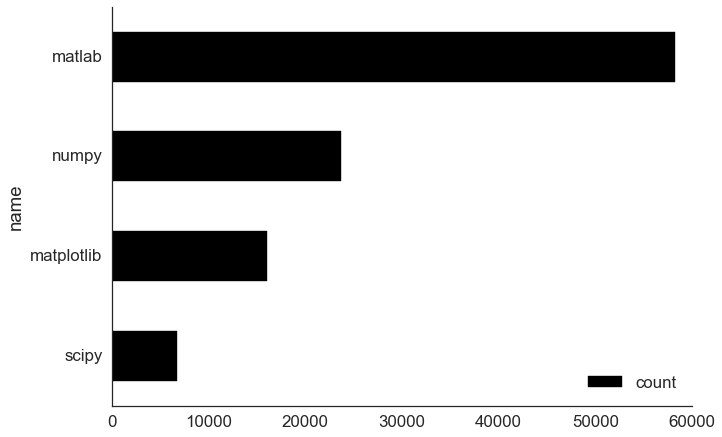

## Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the _Python for Engineers_ course.

The notebook was written using [Python](http://pytho.org/) 3.4.4, [IPython](http://ipython.org/) 4.0.3 and [Jupyter](http://jupyter.org) 4.0.6.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)